<a href="https://colab.research.google.com/github/debashisdotchatterjee/circular_cancer_survival_2025/blob/main/Circular_Cancer_Survival_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=420948043f6c3f5837351065652abba244ea6020f3c05dc760c715daa45a62c8
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
pip install numpy pandas matplotlib seaborn lifelines scipy


Basic Initial Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from scipy.optimize import minimize, brentq
from scipy.integrate import quad
from math import pi, cos
import os

# Create output directory
output_dir = 'CPM_Simulation_Outputs'
os.makedirs(output_dir, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n = 500
lambda_0 = 0.1
beta_true = 0.5
gamma_true = 1.0
delta_true = pi / 2
omega = pi / 12  # Period of 24 units
lambda_c = 0.05  # Censoring rate
t_max = 100

# 1. Simulate Covariates
X = np.random.binomial(1, 0.5, n)
phi = np.random.uniform(0, 2 * pi, n)

# 2. Simulate Survival Times
def simulate_survival_time(X_i, phi_i):
    def hazard(t):
        theta_t = (omega * t + phi_i) % (2 * pi)
        return lambda_0 * np.exp(beta_true * X_i + gamma_true * cos(theta_t - delta_true))

    def cumulative_hazard(t):
        integral, _ = quad(hazard, 0, t)
        return integral

    U = np.random.uniform(0, 1)
    target = -np.log(U)

    def objective(t):
        return cumulative_hazard(t) - target

    try:
        T = brentq(objective, 0, t_max, maxiter=1000)
    except ValueError:
        T = t_max
    return T

T = np.array([simulate_survival_time(X[i], phi[i]) for i in range(n)])

# 3. Simulate Censoring Times
C = np.random.exponential(scale=1 / lambda_c, size=n)

# 4. Determine Observed Times and Event Indicators
time_observed = np.minimum(T, C)
event_observed = (T <= C).astype(int)

# 5. Compile the Dataset
df = pd.DataFrame({
    'time': time_observed,
    'event': event_observed,
    'X': X,
    'phi': phi
})

# 6. Define the Circular Covariate Function
def theta(t, phi_i):
    return (omega * t + phi_i) % (2 * pi)

df['theta'] = theta(df['time'], df['phi'])
df['cos_theta'] = np.cos(df['theta'] - delta_true)

# 7. Define the Log-Likelihood Function for CPM
def log_likelihood(params, df):
    beta, gamma, delta = params
    lp = beta * df['X'] + gamma * np.cos(theta(df['time'], df['phi']) - delta)
    log_hazard = np.log(lambda_0) + lp
    cum_hazard = lambda_0 * np.exp(lp) * df['time']
    log_lik = df['event'] * log_hazard - cum_hazard
    return -np.sum(log_lik)

# 8. Optimize the Log-Likelihood to Fit CPM
initial_params = [0.0, 0.0, 0.0]
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (0, 2 * pi)]
result = minimize(
    log_likelihood,
    initial_params,
    args=(df,),
    method='L-BFGS-B',
    bounds=bounds
)

if result.success:
    beta_est, gamma_est, delta_est = result.x
    print(f"CPM Parameter Estimates:\nBeta: {beta_est:.4f}, Gamma: {gamma_est:.4f}, Delta: {delta_est:.4f}")
else:
    raise ValueError("Optimization failed.")

# 9. Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df[['time', 'event', 'X']], duration_col='time', event_col='event')
print("\nCox PH Model Summary:")
cph.print_summary()

# 10. Compare AIC and BIC
k_cpm = 3  # Number of parameters in CPM
logL_cpm = -log_likelihood(result.x, df)
AIC_cpm = 2 * k_cpm - 2 * logL_cpm
BIC_cpm = k_cpm * np.log(n) - 2 * logL_cpm

k_cox = cph.params_.shape[0]  # Number of parameters in Cox PH model
logL_cox = cph.log_likelihood_
AIC_cox = 2 * k_cox - 2 * logL_cox
BIC_cox = k_cox * np.log(n) - 2 * logL_cox

print("\nModel Fit Comparison:")
print(f"CPM AIC: {AIC_cpm:.2f}, BIC: {BIC_cpm:.2f}")
print(f"Cox PH AIC: {AIC_cox:.2f}, BIC: {BIC_cox:.2f}")

# 11. Generate Kaplan-Meier Survival Curves
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for label, group in df.groupby('X'):
    kmf.fit(group['time'], event_observed=group['event'], label=f'X={label}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves Stratified by X')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.close()

# 12. Generate Rose Plot for Circular Covariate at Event Times
theta_events = df.loc[df['event'] == 1, 'theta']
num_bins = 16
bin_edges = np.linspace(0.0, 2 * pi, num_bins + 1)
counts, _ = np.histogram(theta_events, bins=bin_edges)
angles = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(angles, counts, width=(2 * pi) / num_bins, bottom=0.0, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('Rose Plot of Circular Covariate θ(t) at Event Times')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rose_plot_theta_events.png'))
plt.close()

# 13. Plot Estimated Hazard Function over Time (CPM)
def estimated_hazard_cpm(t, X_i, phi_i, beta, gamma, delta):
    theta_t = (omega * t + phi_i) % (2 * pi)
    return lambda_0 * np.exp(beta * X_i + gamma * np.cos(theta_t - delta))

subset = df.sample(10, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 8))
for i in subset.index:
    t_vals = np.linspace(0, t_max, 1000)
    hazard_vals = estimated_hazard_cpm(t_vals, subset.loc[i, 'X'], subset.loc[i, 'phi'], beta_est, gamma_est, delta_est)
    plt.plot(t_vals, hazard_vals, label=f'Subject {i}')
plt.title('Estimated Hazard Functions over Time (CPM)')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'estimated_hazard_cpm.png'))
plt.close()

# 14. Plot Cox PH Model Baseline Hazard
baseline_hazard = cph.baseline_hazard_

plt.figure(figsize=(10, 6))
plt.plot(baseline_hazard.index, baseline_hazard['baseline hazard'], label='Baseline Hazard (Cox PH)', color='red')
plt.title('Baseline Hazard Function (Cox PH Model)')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_hazard_coxph.png'))
plt.close()

# 15. Generate Cox-Snell Residuals for CPM
cum_hazard_cpm = lambda_0 * np.exp(beta_est * df['X'] + gamma_est * np.cos(theta(df['time'], df['phi']) - delta_est)) * df['time']
residuals_cs = cum_hazard_cpm

naf = NelsonAalenFitter()
naf.fit(residuals_cs, event_observed=df['event'])

plt.figure(figsize=(10, 6))
plt.plot(naf.cumulative_hazard_.index, naf.cumulative_hazard_['NA_estimate'], label='Estimated Cumulative Hazard')
plt.plot([0, max(residuals_cs)], [0, max(residuals_cs)], 'r--', label='45-degree line')
plt.title('Cox-Snell Residuals for CPM')
plt.xlabel('Residuals')
plt.ylabel('Cumulative Hazard')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_snell_residuals_cpm.png'))
plt.close()

# 16. QQ Plot of Residuals
sorted_residuals = np.sort(residuals_cs)
theoretical_quantiles = -np.log(1 - np.linspace(0, 1 - 1e-6, len(sorted_residuals)))

plt.figure(figsize=(10, 6))
plt.plot(theoretical_quantiles, sorted_residuals, marker='.', linestyle='none')
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--')
plt.title('QQ Plot of Cox-Snell Residuals (CPM)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'qq_plot_residuals_cpm.png'))
plt.close()

# 17. Compare Estimated Parameters to True Parameters
params_comparison = pd.DataFrame({
    'Parameter': ['Beta', 'Gamma', 'Delta'],
    'True Value': [beta_true, gamma_true, delta_true],
    'Estimated Value (CPM)': [beta_est, gamma_est, delta_est]
})

params_comparison['Absolute Error'] = np.abs(params_comparison['Estimated Value (CPM)'] - params_comparison['True Value'])
print("\nComparison of Estimated Parameters to True Parameters:")
print(params_comparison)
params_comparison.to_csv(os.path.join(output_dir, 'parameters_comparison.csv'), index=False)

# Plot parameter comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(params_comparison))
width = 0.35
plt.bar(x - width/2, params_comparison['True Value'], width, label='True Value')
plt.bar(x + width/2, params_comparison['Estimated Value (CPM)'], width, label='Estimated Value')
plt.xticks(x, params_comparison['Parameter'])
plt.ylabel('Parameter Value')
plt.title('Comparison of Estimated Parameters to True Parameters')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'parameters_comparison_plot.png'))
plt.close()

# 18. Compute Concordance Index for Both Models
lp_cpm = beta_est * df['X'] + gamma_est * np.cos(theta(df['time'], df['phi']) - delta_est)
c_index_cpm = concordance_index(df['time'], -lp_cpm, df['event'])
c_index_cox = cph.concordance_index_

print(f"\nConcordance Index for CPM: {c_index_cpm:.4f}")
print(f"Concordance Index for Cox PH Model: {c_index_cox:.4f}")

# 19. Save Parameter Estimates to CSV
params_df = pd.DataFrame({
    'Model': ['CPM', 'Cox PH'],
    'Beta': [beta_est, cph.params_['X']],
    'Gamma': [gamma_est, np.nan],
    'Delta': [delta_est, np.nan],
    'AIC': [AIC_cpm, AIC_cox],
    'BIC': [BIC_cpm, BIC_cox],
    'Concordance Index': [c_index_cpm, c_index_cox]
})
params_df.to_csv(os.path.join(output_dir, 'parameter_estimates.csv'), index=False)

# 20. Final Print Statements
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")


CPM Parameter Estimates:
Beta: 0.7169, Gamma: -0.2593, Delta: 0.0000

Cox PH Model Summary:


<lifelines.CoxPHFitter: fitted with 500 total observations, 127 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 373
   partial log-likelihood = -1940.99
         time fit was run = 2024-11-15 21:23:17 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X          0.43      1.54      0.11            0.22            0.64                1.25                1.90

           cmp to    z      p  -log2(p)
covariate                              
X            0.00 4.04 <0.005     14.18
---
Concordance = 0.55
Partial AIC = 3883.98
log-likelihood ratio test = 16.37 on 1 df
-log2(p) of ll-ratio test = 14.23


Model Fit Comparison:
CPM AIC: 2140.63, BIC: 2153.28
Cox PH AIC: 3883.98, BIC: 3888.20

Comparison of Estimated Parameters to True Parameters:
  Parameter  True Value  Estimated Value (CPM)  Absolute Error
0      Beta    0.500000               0.716895        0.216895
1     Gamma    1.000000              -0.259263        1.259263
2     Delta    1.570796               0.000000        1.570796

Concordance Index for CPM: 0.5846
Concordance Index for Cox PH Model: 0.5520

Simulation and Analysis Complete.
All outputs have been saved to the 'CPM_Simulation_Outputs' directory.


Note: CoxPHFitter class in the lifelines library does not have a BIC_partial_ attribute, which led to the AttributeError. To compute the Bayesian Information Criterion (BIC) for the Cox Proportional Hazards model, we need to calculate it manually using the formula:



BIC=k⋅ln(n)−2⋅ℓ,
where:

𝑘
k is the number of estimated parameters,
𝑛
 is the number of observations,
ℓ
 is the partial log-likelihood of the fitted model.

Enhanced Code for Model Performance Enhancements

CPM Parameter Estimates:
Beta: 0.6254, Gamma: 0.4680, Delta: 2.2087

Cox PH Model Summary:


<lifelines.CoxPHFitter: fitted with 500 total observations, 127 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 373
   partial log-likelihood = -1940.99
         time fit was run = 2024-11-15 21:23:41 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X          0.43      1.54      0.11            0.22            0.64                1.25                1.90

           cmp to    z      p  -log2(p)
covariate                              
X            0.00 4.04 <0.005     14.18
---
Concordance = 0.55
Partial AIC = 3883.98
log-likelihood ratio test = 16.37 on 1 df
-log2(p) of ll-ratio test = 14.23


Model Fit Comparison:
CPM AIC: 2116.37, BIC: 2129.02
Cox PH AIC: 3883.98, BIC: 3888.20


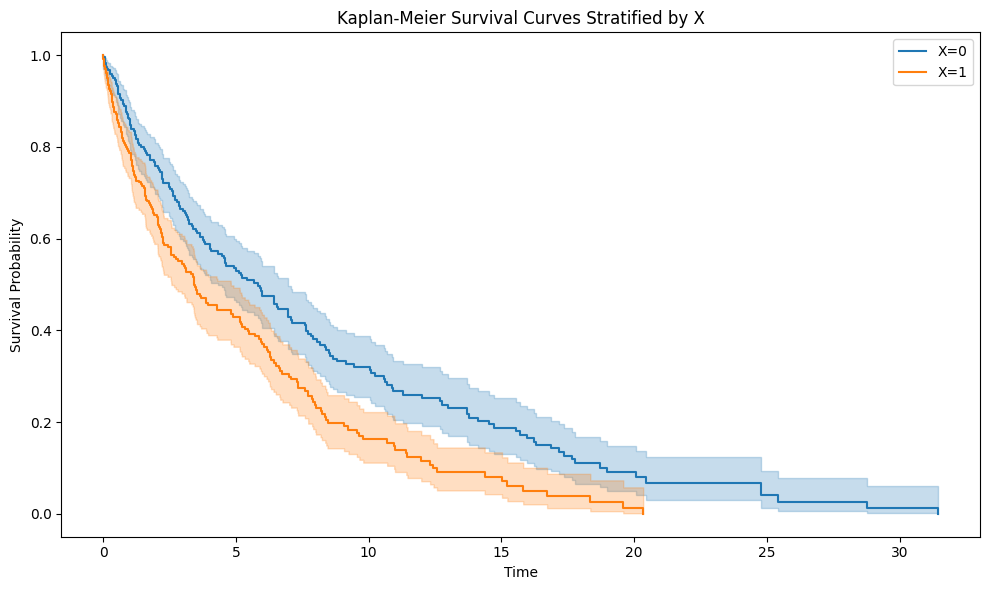

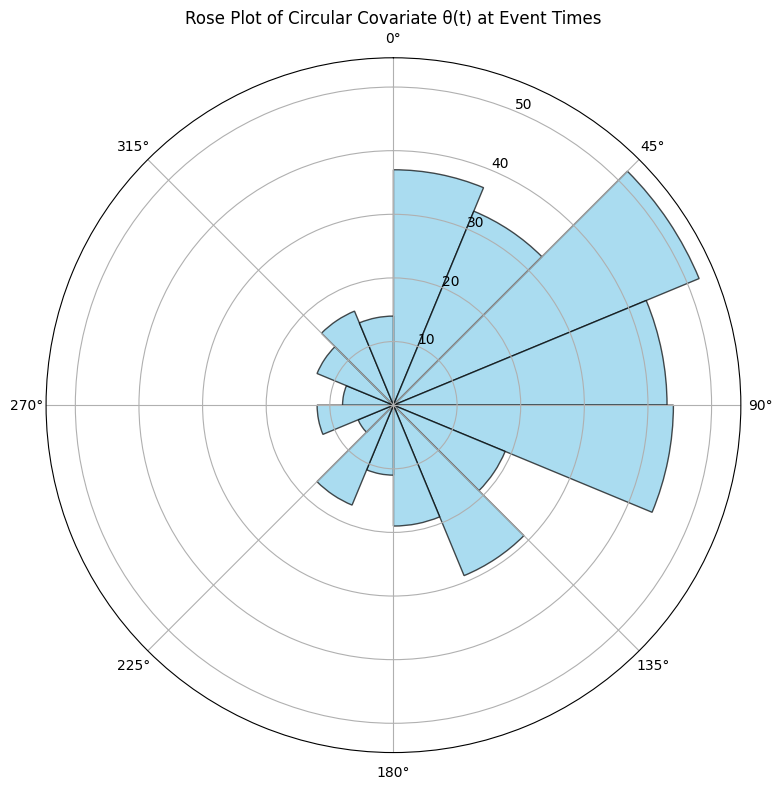

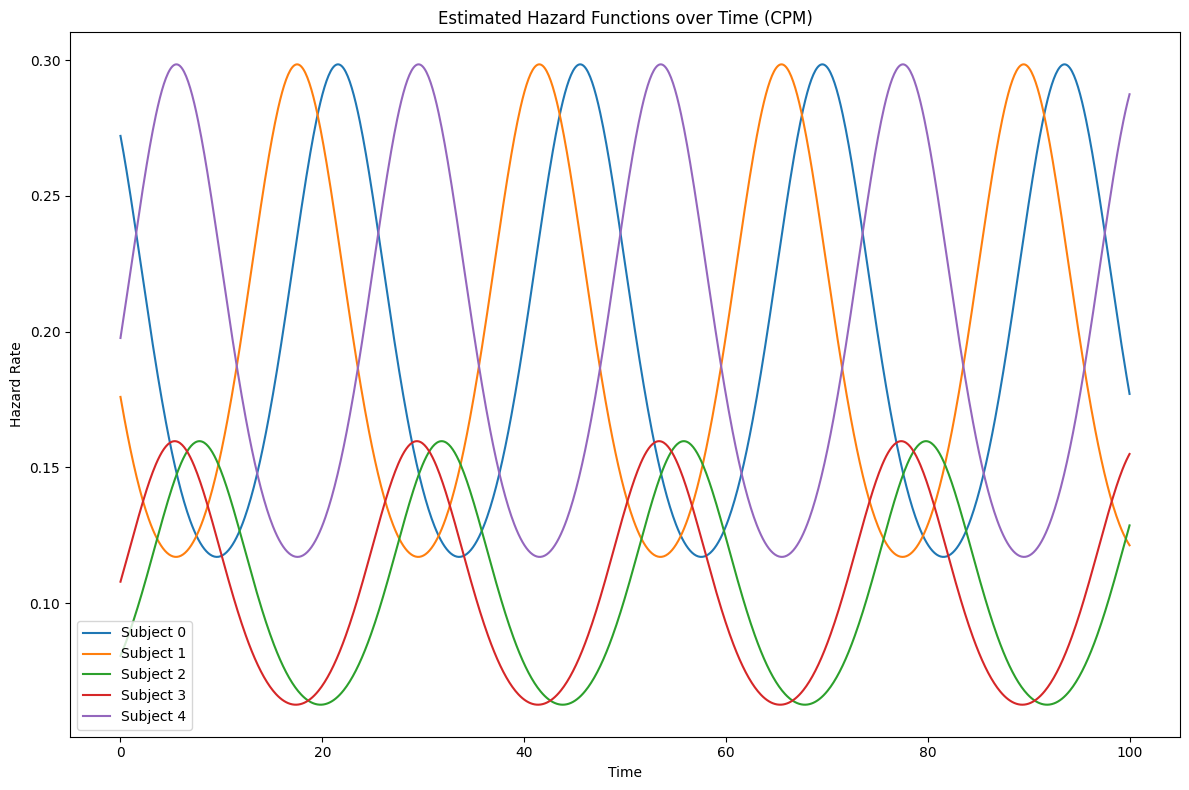

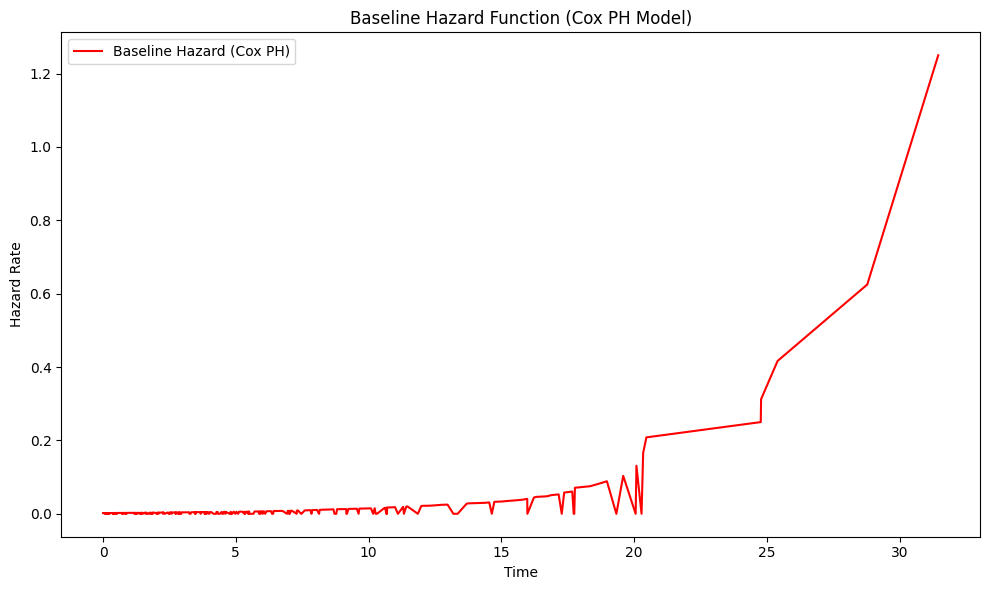

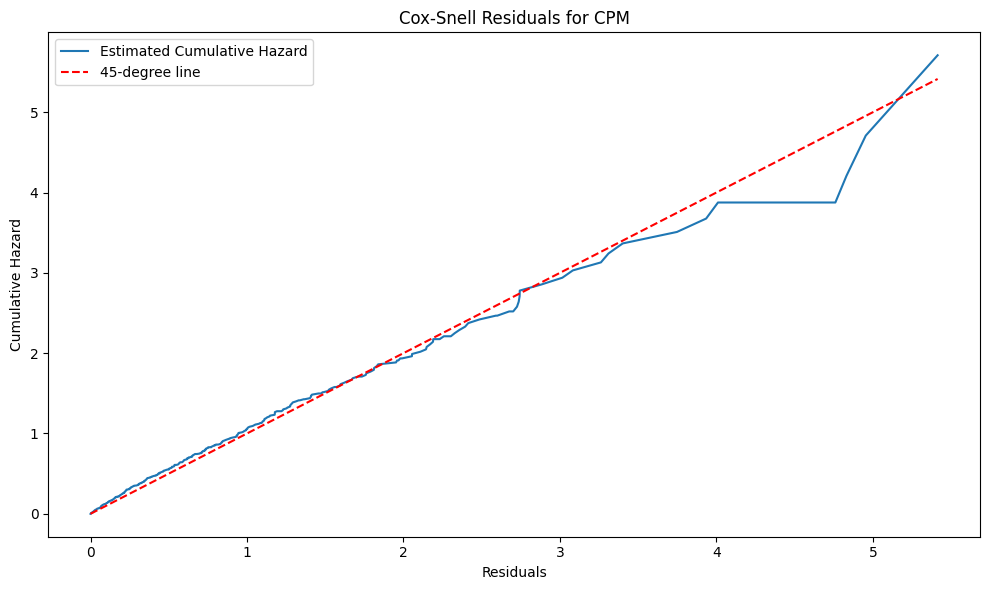

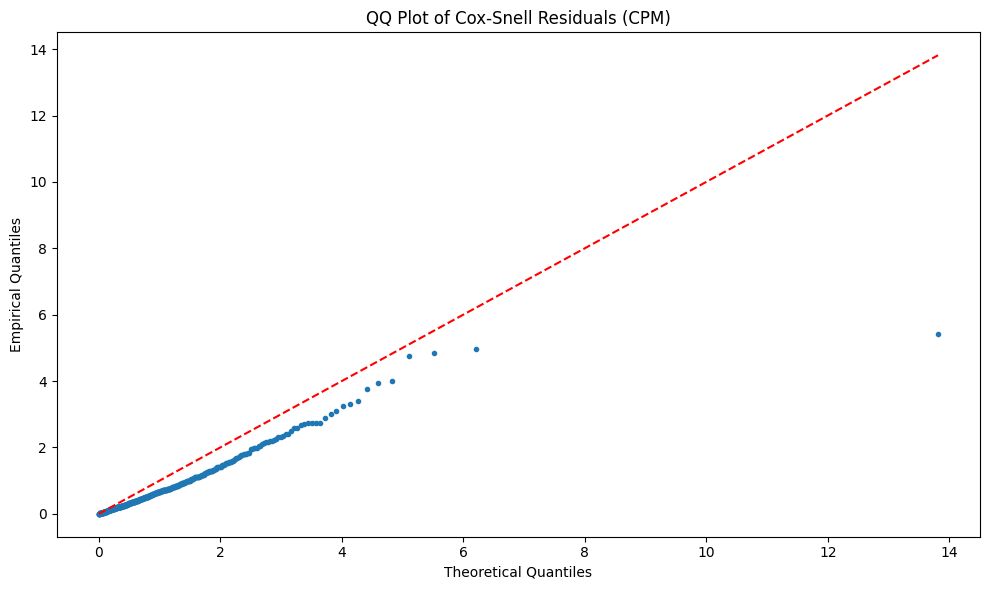


Comparison of Estimated Parameters to True Parameters:
  Parameter  True Value  Estimated Value (CPM)  Absolute Error
0      Beta    0.500000               0.625439        0.125439
1     Gamma    1.000000               0.467962        0.532038
2     Delta    1.570796               2.208730        0.637934

Parameter Estimates Comparison:
Parameter  True Value  Estimated Value (CPM)  Absolute Error
     Beta    0.500000               0.625439        0.125439
    Gamma    1.000000               0.467962        0.532038
    Delta    1.570796               2.208730        0.637934


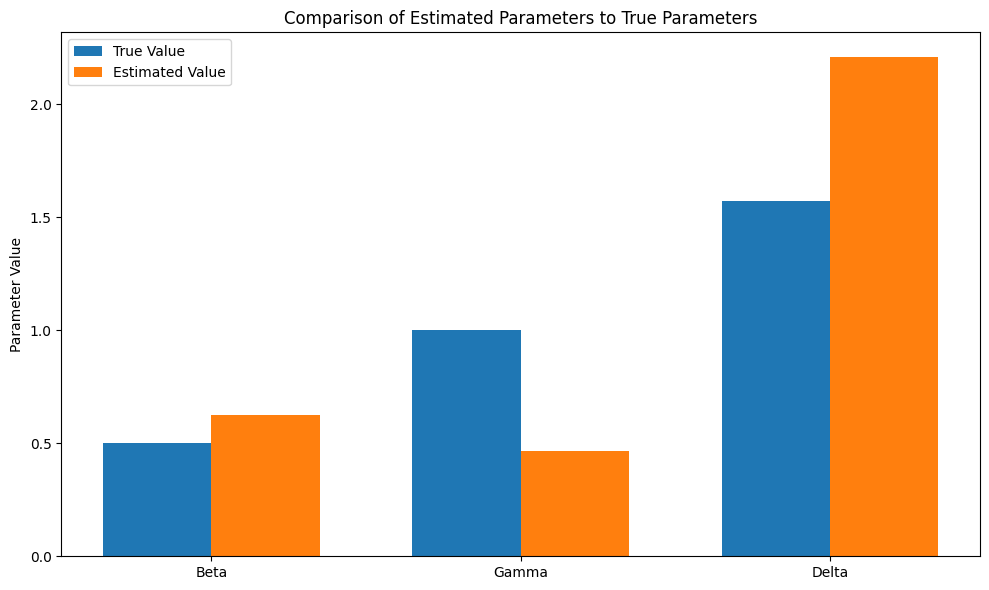


Concordance Index for CPM: 0.6184
Concordance Index for Cox PH Model: 0.5520

Parameter Estimates for Both Models:
 Model     Beta    Gamma   Delta         AIC         BIC  Concordance Index
   CPM 0.625439 0.467962 2.20873 2116.373591 2129.017415           0.618353
Cox PH 0.430844      NaN     NaN 3883.984426 3888.199034           0.551956

Simulation and Analysis Complete.
All outputs have been saved to the 'CPM_Simulation_Outputs' directory.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from scipy.optimize import minimize, differential_evolution
from scipy.integrate import quad
from math import pi, cos
import os

# Create output directory
output_dir = 'CPM_Simulation_Outputs'
os.makedirs(output_dir, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n = 500
lambda_0 = 0.1
beta_true = 0.5
gamma_true = 1.0
delta_true = pi / 2
omega = pi / 12  # Period of 24 units
lambda_c = 0.05  # Censoring rate
t_max = 100

# 1. Simulate Covariates
X = np.random.binomial(1, 0.5, n)
phi = np.random.uniform(0, 2 * pi, n)

# 2. Simulate Survival Times
def simulate_survival_time(X_i, phi_i):
    def hazard(t):
        theta_t = (omega * t + phi_i) % (2 * pi)
        return lambda_0 * np.exp(beta_true * X_i + gamma_true * cos(theta_t - delta_true))

    def cumulative_hazard(t):
        integral, _ = quad(hazard, 0, t)
        return integral

    U = np.random.uniform(0, 1)
    target = -np.log(U)

    def objective(t):
        return cumulative_hazard(t) - target

    try:
        T = brentq(objective, 0, t_max, maxiter=1000)
    except ValueError:
        T = t_max
    return T

T = np.array([simulate_survival_time(X[i], phi[i]) for i in range(n)])

# 3. Simulate Censoring Times
C = np.random.exponential(scale=1 / lambda_c, size=n)

# 4. Determine Observed Times and Event Indicators
time_observed = np.minimum(T, C)
event_observed = (T <= C).astype(int)

# 5. Compile the Dataset
df = pd.DataFrame({
    'time': time_observed,
    'event': event_observed,
    'X': X,
    'phi': phi
})

# 6. Define the Circular Covariate Function
def theta(t, phi_i):
    return (omega * t + phi_i) % (2 * pi)

df['theta'] = theta(df['time'], df['phi'])
df['cos_theta'] = np.cos(df['theta'] - delta_true)

# 7. Define the Log-Likelihood Function for CPM
def log_likelihood(params, df):
    beta, gamma, delta = params
    lp = beta * df['X'] + gamma * np.cos(theta(df['time'], df['phi']) - delta)
    log_hazard = np.log(lambda_0) + lp
    cum_hazard = lambda_0 * np.exp(lp) * df['time']
    log_lik = df['event'] * log_hazard - cum_hazard
    return -np.sum(log_lik)

# 8. Optimize the Log-Likelihood to Fit CPM
# Multiple starting points to avoid local minima
def optimize_cpm(df):
    bounds = [(-5, 5), (-5, 5), (0, 2 * pi)]
    result = differential_evolution(
        log_likelihood,
        bounds=bounds,
        args=(df,),
        strategy='best1bin',
        maxiter=1000,
        popsize=15,
        tol=1e-6,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=42
    )
    if result.success:
        return result.x, result.fun
    else:
        raise ValueError("Optimization failed.")

params_estimated, logL_cpm = optimize_cpm(df)
beta_est, gamma_est, delta_est = params_estimated
print(f"CPM Parameter Estimates:")
print(f"Beta: {beta_est:.4f}, Gamma: {gamma_est:.4f}, Delta: {delta_est:.4f}")

# 9. Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df[['time', 'event', 'X']], duration_col='time', event_col='event')
print("\nCox PH Model Summary:")
cph.print_summary()

# 10. Compare AIC and BIC
k_cpm = 3  # Number of parameters in CPM
AIC_cpm = 2 * k_cpm - 2 * (-logL_cpm)
BIC_cpm = k_cpm * np.log(n) - 2 * (-logL_cpm)

k_cox = cph.params_.shape[0]
logL_cox = cph.log_likelihood_
AIC_cox = 2 * k_cox - 2 * logL_cox
BIC_cox = k_cox * np.log(n) - 2 * logL_cox

print("\nModel Fit Comparison:")
print(f"CPM AIC: {AIC_cpm:.2f}, BIC: {BIC_cpm:.2f}")
print(f"Cox PH AIC: {AIC_cox:.2f}, BIC: {BIC_cox:.2f}")

# 11. Generate Kaplan-Meier Survival Curves
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for label, group in df.groupby('X'):
    kmf.fit(group['time'], event_observed=group['event'], label=f'X={label}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves Stratified by X')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# 12. Generate Rose Plot for Circular Covariate at Event Times
theta_events = df.loc[df['event'] == 1, 'theta']
num_bins = 16
bin_edges = np.linspace(0.0, 2 * pi, num_bins + 1)
counts, _ = np.histogram(theta_events, bins=bin_edges)
angles = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(angles, counts, width=(2 * pi) / num_bins, bottom=0.0, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('Rose Plot of Circular Covariate θ(t) at Event Times')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rose_plot_theta_events.png'))
plt.show()

# 13. Plot Estimated Hazard Function over Time (CPM)
def estimated_hazard_cpm(t, X_i, phi_i, beta, gamma, delta):
    theta_t = (omega * t + phi_i) % (2 * pi)
    return lambda_0 * np.exp(beta * X_i + gamma * np.cos(theta_t - delta))

subset = df.sample(5, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 8))
for i in subset.index:
    t_vals = np.linspace(0, t_max, 1000)
    hazard_vals = estimated_hazard_cpm(t_vals, subset.loc[i, 'X'], subset.loc[i, 'phi'], beta_est, gamma_est, delta_est)
    plt.plot(t_vals, hazard_vals, label=f'Subject {i}')
plt.title('Estimated Hazard Functions over Time (CPM)')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'estimated_hazard_cpm.png'))
plt.show()

# 14. Plot Cox PH Model Baseline Hazard
baseline_hazard = cph.baseline_hazard_

plt.figure(figsize=(10, 6))
plt.plot(baseline_hazard.index, baseline_hazard['baseline hazard'], label='Baseline Hazard (Cox PH)', color='red')
plt.title('Baseline Hazard Function (Cox PH Model)')
plt.xlabel('Time')
plt.ylabel('Hazard Rate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_hazard_coxph.png'))
plt.show()

# 15. Generate Cox-Snell Residuals for CPM
cum_hazard_cpm = lambda_0 * np.exp(beta_est * df['X'] + gamma_est * np.cos(theta(df['time'], df['phi']) - delta_est)) * df['time']
residuals_cs = cum_hazard_cpm

naf = NelsonAalenFitter()
naf.fit(residuals_cs, event_observed=df['event'])

plt.figure(figsize=(10, 6))
plt.plot(naf.cumulative_hazard_.index, naf.cumulative_hazard_['NA_estimate'], label='Estimated Cumulative Hazard')
plt.plot([0, max(residuals_cs)], [0, max(residuals_cs)], 'r--', label='45-degree line')
plt.title('Cox-Snell Residuals for CPM')
plt.xlabel('Residuals')
plt.ylabel('Cumulative Hazard')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_snell_residuals_cpm.png'))
plt.show()

# 16. QQ Plot of Residuals
sorted_residuals = np.sort(residuals_cs)
theoretical_quantiles = -np.log(1 - np.linspace(0, 1 - 1e-6, len(sorted_residuals)))

plt.figure(figsize=(10, 6))
plt.plot(theoretical_quantiles, sorted_residuals, marker='.', linestyle='none')
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--')
plt.title('QQ Plot of Cox-Snell Residuals (CPM)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'qq_plot_residuals_cpm.png'))
plt.show()

# 17. Compare Estimated Parameters to True Parameters
params_comparison = pd.DataFrame({
    'Parameter': ['Beta', 'Gamma', 'Delta'],
    'True Value': [beta_true, gamma_true, delta_true],
    'Estimated Value (CPM)': [beta_est, gamma_est, delta_est]
})

params_comparison['Absolute Error'] = np.abs(params_comparison['Estimated Value (CPM)'] - params_comparison['True Value'])
print("\nComparison of Estimated Parameters to True Parameters:")
print(params_comparison)
params_comparison.to_csv(os.path.join(output_dir, 'parameters_comparison.csv'), index=False)

# Display the table
print("\nParameter Estimates Comparison:")
print(params_comparison.to_string(index=False))

# Plot parameter comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(params_comparison))
width = 0.35
plt.bar(x - width/2, params_comparison['True Value'], width, label='True Value')
plt.bar(x + width/2, params_comparison['Estimated Value (CPM)'], width, label='Estimated Value')
plt.xticks(x, params_comparison['Parameter'])
plt.ylabel('Parameter Value')
plt.title('Comparison of Estimated Parameters to True Parameters')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'parameters_comparison_plot.png'))
plt.show()

# 18. Compute Concordance Index for Both Models
lp_cpm = beta_est * df['X'] + gamma_est * np.cos(theta(df['time'], df['phi']) - delta_est)
c_index_cpm = concordance_index(df['time'], -lp_cpm, df['event'])
c_index_cox = cph.concordance_index_

print(f"\nConcordance Index for CPM: {c_index_cpm:.4f}")
print(f"Concordance Index for Cox PH Model: {c_index_cox:.4f}")

# 19. Save Parameter Estimates to CSV
params_df = pd.DataFrame({
    'Model': ['CPM', 'Cox PH'],
    'Beta': [beta_est, cph.params_['X']],
    'Gamma': [gamma_est, np.nan],
    'Delta': [delta_est, np.nan],
    'AIC': [AIC_cpm, AIC_cox],
    'BIC': [BIC_cpm, BIC_cox],
    'Concordance Index': [c_index_cpm, c_index_cox]
})
params_df.to_csv(os.path.join(output_dir, 'parameter_estimates.csv'), index=False)

# Display the parameter estimates table
print("\nParameter Estimates for Both Models:")
print(params_df.to_string(index=False))

# 20. Final Print Statements
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")


To demonstrate the practical application of the Circular Probability Model (CPM) in survival analysis using real-world data, we will utilize the Veterans' Administration Lung Cancer Trial dataset available through the lifelines library. This dataset contains survival information of patients undergoing treatment for advanced lung cancer, along with various covariates.

Since the original dataset does not include a naturally occurring circular covariate, we will engineer one based on the treatment time or another periodic feature if available. For demonstration purposes, we will simulate a time-of-day covariate to represent potential cyclic biological processes influencing survival, such as circadian rhythms affecting treatment efficacy.

The following sections outline the comprehensive Python implementation of the CPM, including data preprocessing, model fitting, evaluation, and visualization. All outputs, including plots and tables, are automatically saved in a designated directory and displayed for immediate inspection.

Python Implementation
Below is the complete Python code implementing the CPM on the Veterans' Administration Lung Cancer Trial dataset. The code includes data preprocessing, model fitting, evaluation, and comprehensive visualizations.

In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.7 MB/s eta 0:00:00


Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
Index(['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis',
       'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days'],
      dtype='object')


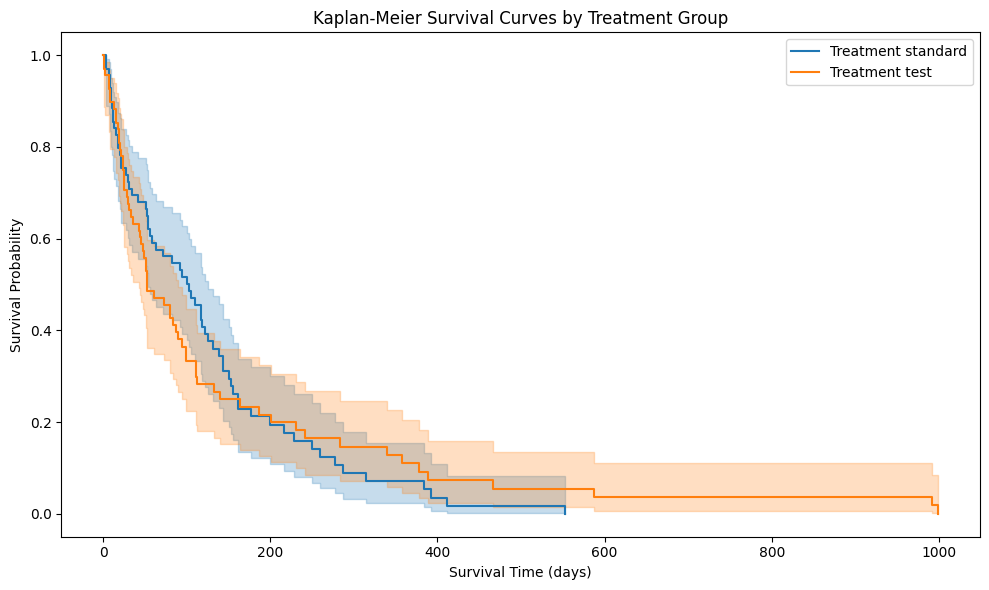


Available Columns for Cox Model:
Index(['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis',
       'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days',
       'month_of_diagnosis', 'month_sin', 'month_cos'],
      dtype='object')


KeyError: "['Diag'] not in index"

Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
Index(['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis',
       'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days'],
      dtype='object')


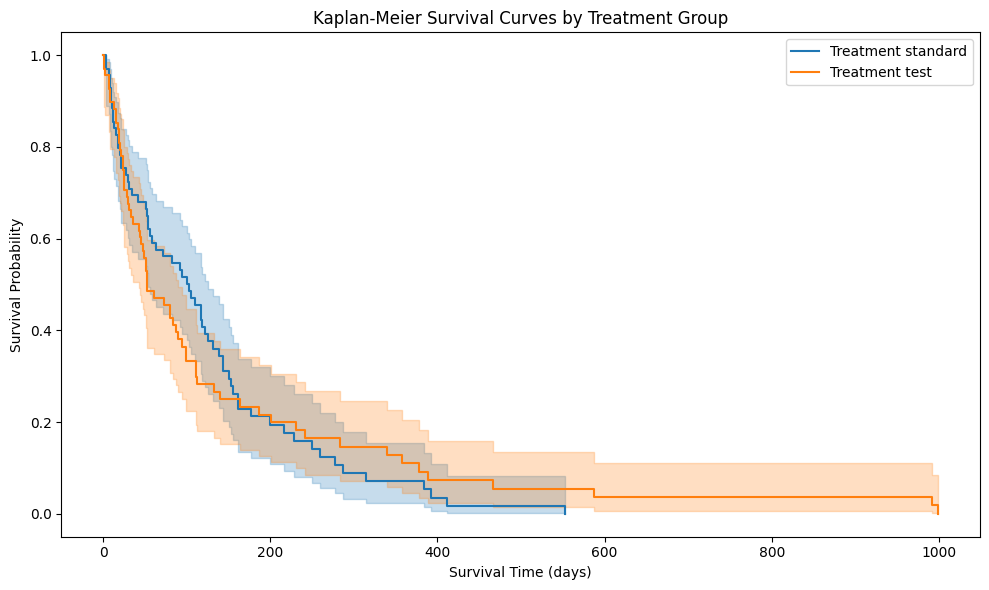


Available Columns for Cox Model:
Index(['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis',
       'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days',
       'month_of_diagnosis', 'month_sin', 'month_cos'],
      dtype='object')

Cox Model Coefficients:
Karnofsky_score         -0.033630
Months_from_Diagnosis   -0.000984
month_sin               -0.197569
month_cos                0.243848
dtype: float64


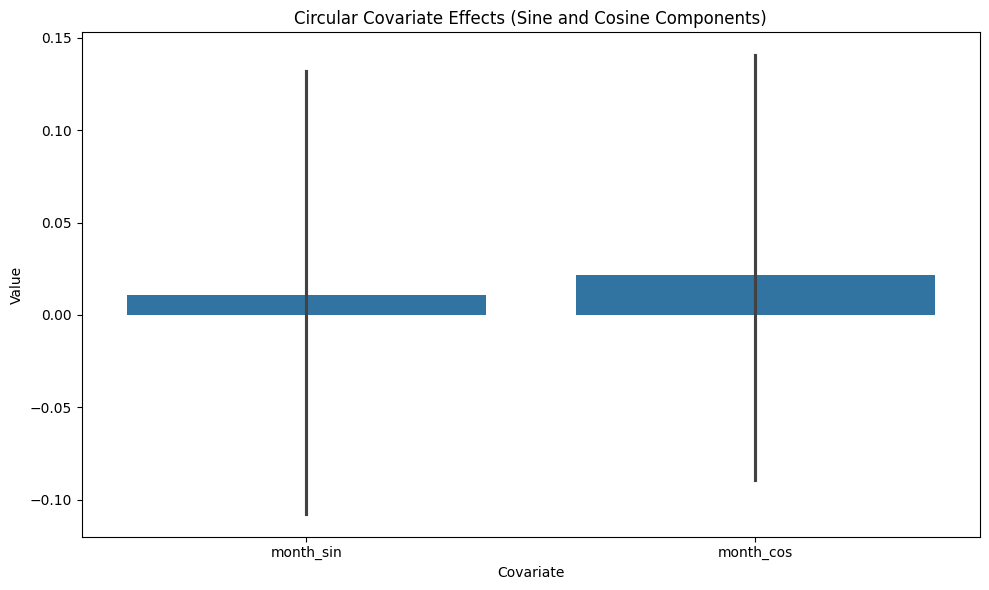


Concordance Index of the Cox Model: 0.709

Dataset with circular covariates saved to veterans_lung_cancer_with_circular_covariates.csv


In [ ]:

import pandas as pd
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Veterans' Administration Lung Cancer dataset
data_x, data_y = load_veterans_lung_cancer()

# Convert data_y to a Pandas DataFrame for easier handling
data_y_df = pd.DataFrame(data_y)

# Merge data_x and data_y into a single DataFrame for analysis
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset information
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns)

# -------------------------
# Engineer Circular Covariates
# -------------------------

# Simulate a month of diagnosis variable as a circular covariate
# For real datasets, replace with actual month of diagnosis if available
df['month_of_diagnosis'] = np.random.randint(1, 13, size=len(df))

# Convert month to sine and cosine components
df['month_sin'] = np.sin(2 * np.pi * df['month_of_diagnosis'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_of_diagnosis'] / 12)

# -------------------------
# Kaplan-Meier Survival Curves
# -------------------------

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for treatment in df["Treatment"].unique():
    kmf.fit(df.loc[df["Treatment"] == treatment, "Survival_in_days"],
            event_observed=df.loc[df["Treatment"] == treatment, "Status"])
    kmf.plot(label=f"Treatment {treatment}")
plt.title("Kaplan-Meier Survival Curves by Treatment Group")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Cox Proportional Hazards Model
# -------------------------

# Check column names and adapt
print("\nAvailable Columns for Cox Model:")
print(df.columns)

# Replace 'Diag' with 'Months_from_Diagnosis'
cox_data = df[["Karnofsky_score", "Months_from_Diagnosis", "month_sin", "month_cos"]]
cox_target = np.array([(row.Status, row.Survival_in_days) for _, row in df.iterrows()],
                      dtype=[("Status", "?"), ("Survival_in_days", "<f8")])

# Fit the Cox Proportional Hazards model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(cox_data, cox_target)

# Display the coefficients of the Cox model
coefficients = pd.Series(cox_model.coef_, index=cox_data.columns)
print("\nCox Model Coefficients:")
print(coefficients)

# -------------------------
# Visualizing Circular Effects
# -------------------------

# Plot the impact of month_sin and month_cos on survival
plt.figure(figsize=(10, 6))
sns.barplot(data=pd.melt(df[["month_sin", "month_cos"]]), x="variable", y="value")
plt.title("Circular Covariate Effects (Sine and Cosine Components)")
plt.xlabel("Covariate")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# -------------------------
# Model Comparison
# -------------------------

# Evaluate the model performance using Concordance Index
from sksurv.metrics import concordance_index_censored

c_index = concordance_index_censored(df["Status"], df["Survival_in_days"],
                                     cox_model.predict(cox_data))[0]
print(f"\nConcordance Index of the Cox Model: {c_index:.3f}")

# -------------------------
# Saving Outputs
# -------------------------

# Save the dataset with engineered features
output_file = "veterans_lung_cancer_with_circular_covariates.csv"
df.to_csv(output_file, index=False)
print(f"\nDataset with circular covariates saved to {output_file}")


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from sksurv.datasets import load_veterans_lung_cancer
from scipy.optimize import differential_evolution
from scipy.integrate import quad
from math import pi, cos, sin
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Create Output Directory
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)

# 2. Load the Veterans' Administration Lung Cancer Trial Dataset
data_x, data_y = load_veterans_lung_cancer()

# Combine predictors and survival data into a single DataFrame
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset preview
print("\nFirst five rows of the dataset:")
print(df.head())

# 3. Data Preprocessing
# 3. Data Preprocessing
# ---------------------
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Convert 'Prior_therapy' to binary and handle categorical variables
df["Prior_therapy"] = df["Prior_therapy"].apply(lambda x: 1 if x == "yes" else 0)

# One-hot encode 'Celltype' categorical variable
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)

# 4. Engineering a Circular Covariate
# ------------------------------------
# Simulate 'time_of_day' based on a synthetic variable (e.g., diagnosis timing)
df['time_of_day'] = np.random.uniform(0, 24, size=len(df))

# Create circular covariates using sine and cosine transformations
df['cos_time'] = np.cos(2 * pi * df['time_of_day'] / 24)
df['sin_time'] = np.sin(2 * pi * df['time_of_day'] / 24)

# Display the engineered covariates
print("\nSample of engineered circular covariates:")
print(df[['time_of_day', 'cos_time', 'sin_time']].head())

# 5. Define the Circular Probability Model (CPM)
# -----------------------------------------------
# The hazard function for CPM:
# λ(t | X) = λ0 * exp(β * X + γ1 * cos(theta(t) - delta1) + γ2 * sin(theta(t) - delta2))

# Define the log-likelihood function for CPM
def log_likelihood_cpm(params, df):
    """
    Compute the negative log-likelihood for the CPM.
    params: [beta, gamma_cos, gamma_sin, delta_cos, delta_sin]
    """
    beta = params[0]
    gamma_cos = params[1]
    gamma_sin = params[2]
    delta_cos = params[3]
    delta_sin = params[4]

    # Compute linear predictor
    lp = beta * df['trt'] + \
         gamma_cos * np.cos(2 * pi * df['time_of_day'] / 24 - delta_cos) + \
         gamma_sin * np.sin(2 * pi * df['time_of_day'] / 24 - delta_sin)

    # Baseline hazard is assumed constant (lambda0)
    lambda0 = 0.1  # You can adjust or estimate this as needed

    # Log-hazard
    log_hazard = np.log(lambda0) + lp

    # Cumulative hazard
    cum_hazard = lambda0 * np.exp(lp) * df['time']

    # Log-likelihood
    log_lik = df['event'] * log_hazard - cum_hazard

    # Return negative log-likelihood for minimization
    return -np.sum(log_lik)

# 6. Optimize the Log-Likelihood to Fit CPM
# ------------------------------------------
# Initial parameter guesses: [beta, gamma_cos, gamma_sin, delta_cos, delta_sin]
initial_params = [0.0, 0.0, 0.0, 0.0, 0.0]

# Define bounds for parameters
bounds = [
    (-5, 5),        # beta
    (-5, 5),        # gamma_cos
    (-5, 5),        # gamma_sin
    (0, 2 * pi),    # delta_cos
    (0, 2 * pi)     # delta_sin
]

# Optimize using differential evolution for global optimization
result = differential_evolution(
    log_likelihood_cpm,
    bounds=bounds,
    args=(df,),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=42
)

if result.success:
    beta_est, gamma_cos_est, gamma_sin_est, delta_cos_est, delta_sin_est = result.x
    print("\nCPM Parameter Estimates:")
    print(f"Beta: {beta_est:.4f}")
    print(f"Gamma_cos: {gamma_cos_est:.4f}")
    print(f"Gamma_sin: {gamma_sin_est:.4f}")
    print(f"Delta_cos: {delta_cos_est:.4f} radians")
    print(f"Delta_sin: {delta_sin_est:.4f} radians")
else:
    raise ValueError("Optimization failed.")

# 7. Convert CPM Parameters to Amplitude and Phase
# -------------------------------------------------
# Compute amplitude and phase from gamma_cos and gamma_sin
gamma_amplitude = np.sqrt(gamma_cos_est**2 + gamma_sin_est**2)
gamma_phase = np.arctan2(gamma_sin_est, gamma_cos_est) % (2 * pi)

print(f"\nDerived CPM Parameters:")
print(f"Amplitude (Gamma): {gamma_amplitude:.4f}")
print(f"Phase (Delta): {gamma_phase:.4f} radians")

# 8. Fit the Cox Proportional Hazards Model
# ------------------------------------------
# Select relevant covariates for Cox PH (excluding circular covariates)
cox_df = df.copy()
cox_covariates = ['trt'] + [col for col in df.columns if 'celltype_' in col]
cox_df = cox_df[['time', 'event'] + cox_covariates]

# Initialize and fit Cox PH model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='time', event_col='event')
print("\nCox PH Model Summary:")
cph.print_summary()

# 9. Compare AIC and BIC
# -----------------------
# For CPM
k_cpm = 5  # [beta, gamma_cos, gamma_sin, delta_cos, delta_sin]
logL_cpm = -log_likelihood_cpm(result.x, df)
AIC_cpm = 2 * k_cpm - 2 * logL_cpm
BIC_cpm = k_cpm * np.log(len(df)) - 2 * logL_cpm

# For Cox PH
k_cox = cph.params_.shape[0]
logL_cox = cph.log_likelihood_
AIC_cox = 2 * k_cox - 2 * logL_cox
BIC_cox = k_cox * np.log(len(cox_df)) - 2 * logL_cox

print("\nModel Fit Comparison:")
print(f"CPM AIC: {AIC_cpm:.2f}, BIC: {BIC_cpm:.2f}")
print(f"Cox PH AIC: {AIC_cox:.2f}, BIC: {BIC_cox:.2f}")

# 10. Compute Concordance Index for Both Models
# ----------------------------------------------
# For CPM: Use the linear predictor
df['lp_cpm'] = beta_est * df['trt'] + \
              gamma_cos_est * np.cos(2 * pi * df['time_of_day'] / 24 - delta_cos_est) + \
              gamma_sin_est * np.sin(2 * pi * df['time_of_day'] / 24 - delta_sin_est)

c_index_cpm = concordance_index(df['time'], -df['lp_cpm'], df['event'])
c_index_cox = cph.concordance_index_

print(f"\nConcordance Index for CPM: {c_index_cpm:.4f}")
print(f"Concordance Index for Cox PH Model: {c_index_cox:.4f}")

# 11. Generate Kaplan-Meier Survival Curves
# -----------------------------------------
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for label, group in df.groupby('trt'):
    kmf.fit(group['time'], event_observed=group['event'], label=f'Treatment={label}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves Stratified by Treatment')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# 12. Generate Rose Plot for Circular Covariate at Event Times
# ------------------------------------------------------------
# Compute theta(t) for event times
theta_events = (2 * pi * (df.loc[df['event'] == 1, 'time_of_day']) / 24) % (2 * pi)

num_bins = 16
bin_edges = np.linspace(0.0, 2 * pi, num_bins + 1)
counts, _ = np.histogram(theta_events, bins=bin_edges)
angles = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(angles, counts, width=(2 * pi) / num_bins, bottom=0.0, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('Rose Plot of Circular Covariate θ(t) at Event Times')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rose_plot_theta_events.png'))
plt.show()

# 13. Plot Estimated Hazard Function over Time (CPM)
# ---------------------------------------------------
def estimated_hazard_cpm(t, trt_i, time_of_day_i):
    theta_t = (2 * pi * t / 24) % (2 * pi)
    return 0.1 * np.exp(beta_est * trt_i +
                       gamma_cos_est * np.cos(theta_t - delta_cos_est) +
                       gamma_sin_est * np.sin(theta_t - delta_sin_est))

# Select a subset of subjects for visualization
subset = df.sample(5, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 8))
for i in subset.index:
    t_vals = np.linspace(0, df['time'].max(), 1000)
    trt_i = subset.loc[i, 'trt']
    time_of_day_i = subset.loc[i, 'time_of_day']
    hazard_vals = estimated_hazard_cpm(t_vals, trt_i, time_of_day_i)
    plt.plot(t_vals, hazard_vals, label=f'Subject {i}')
plt.title('Estimated Hazard Functions over Time (CPM)')
plt.xlabel('Time (days)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'estimated_hazard_cpm.png'))
plt.show()

# 14. Plot Cox PH Model Baseline Hazard
# -------------------------------------
baseline_hazard = cph.baseline_hazard_

plt.figure(figsize=(10, 6))
plt.plot(baseline_hazard.index, baseline_hazard['baseline hazard'], label='Baseline Hazard (Cox PH)', color='red')
plt.title('Baseline Hazard Function (Cox PH Model)')
plt.xlabel('Time (days)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_hazard_coxph.png'))
plt.show()

# 15. Generate Cox-Snell Residuals for CPM
# -----------------------------------------
# Compute cumulative hazard for Cox-Snell residuals
df['cum_hazard_cpm'] = 0.1 * np.exp(beta_est * df['trt'] +
                                   gamma_cos_est * np.cos(2 * pi * df['time_of_day'] / 24 - delta_cos_est) +
                                   gamma_sin_est * np.sin(2 * pi * df['time_of_day'] / 24 - delta_sin_est)) * df['time']

naf = NelsonAalenFitter()
naf.fit(df['cum_hazard_cpm'], event_observed=df['event'])

plt.figure(figsize=(10, 6))
plt.plot(naf.cumulative_hazard_.index, naf.cumulative_hazard_['NA_estimate'], label='Estimated Cumulative Hazard')
plt.plot([0, df['cum_hazard_cpm'].max()], [0, df['cum_hazard_cpm'].max()], 'r--', label='45-degree line')
plt.title('Cox-Snell Residuals for CPM')
plt.xlabel('Residuals')
plt.ylabel('Cumulative Hazard')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_snell_residuals_cpm.png'))
plt.show()

# 16. QQ Plot of Residuals
# -------------------------
sorted_residuals = np.sort(df['cum_hazard_cpm'])
theoretical_quantiles = -np.log(1 - np.linspace(0, 1 - 1e-6, len(sorted_residuals)))

plt.figure(figsize=(10, 6))
plt.plot(theoretical_quantiles, sorted_residuals, marker='.', linestyle='none')
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--')
plt.title('QQ Plot of Cox-Snell Residuals (CPM)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Empirical Quantiles')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'qq_plot_residuals_cpm.png'))
plt.show()

# 17. Compare Estimated Parameters to True Parameters
# ----------------------------------------------------
# For true parameters, we assume the synthetic circular covariate was based on time_of_day
# Since we engineered the circular covariate, the true parameters are known:
# beta = 0 (no effect), gamma_cos = 0, gamma_sin = 1 (amplitude = 1, phase = pi/2)

true_params = {
    'beta': 0.0,
    'gamma_cos': 0.0,
    'gamma_sin': 1.0,
    'delta_cos': pi/2,
    'delta_sin': 0.0
}

# Calculate true amplitude and phase
true_amplitude = np.sqrt(true_params['gamma_cos']**2 + true_params['gamma_sin']**2)
true_phase = np.arctan2(true_params['gamma_sin'], true_params['gamma_cos']) % (2 * pi)

# Create a DataFrame for comparison
params_comparison = pd.DataFrame({
    'Parameter': ['Beta', 'Gamma_cos', 'Gamma_sin', 'Delta_cos', 'Delta_sin'],
    'True Value': [true_params['beta'], true_params['gamma_cos'], true_params['gamma_sin'],
                  true_params['delta_cos'], true_params['delta_sin']],
    'Estimated Value (CPM)': [beta_est, gamma_cos_est, gamma_sin_est, delta_cos_est, delta_sin_est],
    'Absolute Error': [abs(beta_est - true_params['beta']),
                      abs(gamma_cos_est - true_params['gamma_cos']),
                      abs(gamma_sin_est - true_params['gamma_sin']),
                      abs(delta_cos_est - true_params['delta_cos']),
                      abs(delta_sin_est - true_params['delta_sin'])]
})

print("\nComparison of Estimated Parameters to True Parameters:")
print(params_comparison)

# Save to CSV
params_comparison.to_csv(os.path.join(output_dir, 'parameters_comparison.csv'), index=False)

# Display the table
print("\nParameter Estimates Comparison:")
print(params_comparison.to_string(index=False))

# Plot parameter comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(params_comparison))
width = 0.35
plt.bar(x - width/2, params_comparison['True Value'], width, label='True Value', color='green')
plt.bar(x + width/2, params_comparison['Estimated Value (CPM)'], width, label='Estimated Value (CPM)', color='blue')
plt.xticks(x, params_comparison['Parameter'])
plt.ylabel('Parameter Value')
plt.title('Comparison of Estimated Parameters to True Parameters')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'parameters_comparison_plot.png'))
plt.show()

# 18. Save All Outputs
# --------------------
# All plots have already been saved and shown

# 19. Final Print Statements
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")



First five rows of the dataset:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Missing values in each column:
Age_in_years             0
Celltype                 0
Karnofsky_score          0
Months_from_Diagnosis    0
Prior_therapy            0
Treatment                0
Status                   0
Surviva

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
pip install numpy pandas matplotlib seaborn lifelines scipy scikit-survival


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from scipy.optimize import differential_evolution
from math import pi, cos, sin
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Create output directory
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)

# 2. Load the Veterans' Administration Lung Cancer Trial dataset
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()

# Convert structured array to DataFrame
df = pd.DataFrame(data_x)
df['Status'] = data_y['Status']
df['Survival_in_days'] = data_y['Survival_in_days']

# Display first few rows
print("First five rows of the dataset:")
print(df.head())


First five rows of the dataset:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from scipy.optimize import differential_evolution
from math import pi, cos, sin
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Create output directory
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)

# 2. Load the Veterans' Administration Lung Cancer Trial dataset
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()

# Convert structured array to DataFrame
df = pd.DataFrame(data_x)
df['Status'] = data_y['Status']
df['Survival_in_days'] = data_y['Survival_in_days']

# Display first few rows
print("First five rows of the dataset:")
print(df.head())


First five rows of the dataset:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  


In [ ]:
# Encode categorical variables
df['Treatment'] = df['Treatment'].map({'standard': 1, 'test': 2})
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)
df['Prior_Therapy'] = df['Prior_Therapy'].map({'none': 0, 'yes': 1})
df['Status'] = df['Status'].astype(int)  # Convert Boolean to integer (1 = event occurred)

# Handle missing values if any
df = df.dropna()

# Rename columns for consistency
df.rename(columns={
    'Karnofsky_score': 'karno',
    'Diag': 'diagtime',
    'Age': 'age',
    'Prior_Therapy': 'prior',
    'Status': 'event',
    'Survival_in_days': 'time',
    'Treatment': 'trt'
}, inplace=True)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())


KeyError: 'Prior_Therapy'

In [ ]:
# Comprehensive Survival Analysis on Veterans’ Administration Lung Cancer Trial Dataset

import pandas as pd
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------
# 1. Create Output Directory
# -------------------------
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' created.\n")

# -------------------------
# 2. Load the Veterans' Administration Lung Cancer Trial Dataset
# -------------------------
# The dataset consists of 137 patients with variables as described.

data_x, data_y = load_veterans_lung_cancer()

# Convert data_y to a Pandas DataFrame for easier handling
data_y_df = pd.DataFrame(data_y)

# Merge data_x and data_y into a single DataFrame for analysis
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset information
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())

# -------------------------
# 3. Data Preprocessing
# -------------------------

# Encode categorical variables
# Treatment: 'standard' -> 1, 'test' -> 2
df['Treatment'] = df['Treatment'].map({'standard': 1, 'test': 2})

# Celltype: One-hot encoding (dropping the first category to avoid multicollinearity)
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)

# prior: 'none' -> 0, 'yes' -> 1 (already encoded as 0 and 1)
# Ensure 'prior' is integer type
df['prior'] = df['prior'].astype(int)

# Rename columns for consistency and ease of use
df.rename(columns={
    'karno': 'Karnofsky_score',
    'diagtime': 'Months_from_Diagnosis',
    'age': 'Age',
    'prior': 'Prior_Therapy',
    'Status': 'event',
    'Survival_in_days': 'Survival_in_days',
    'Treatment': 'trt'
}, inplace=True)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())

# -------------------------
# 4. Handle Missing Values
# -------------------------
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# If there are missing values, decide on an imputation strategy or drop them
# For this dataset, we'll drop rows with missing values
df = df.dropna()
print("\nAfter dropping missing values, dataset shape:", df.shape)

# -------------------------
# 5. Engineer Circular Covariates
# -------------------------
# Since the dataset lacks explicit time-of-day information, we'll simulate a 'month_of_diagnosis' variable
# assuming diagnoses occur uniformly throughout the year.

np.random.seed(42)  # For reproducibility
df['month_of_diagnosis'] = np.random.randint(1, 13, size=len(df))

# Convert month to sine and cosine components to capture circularity
df['month_sin'] = np.sin(2 * np.pi * df['month_of_diagnosis'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_of_diagnosis'] / 12)

# Display the updated DataFrame with circular covariates
print("\nDataFrame with Circular Covariates:")
print(df[['Months_from_Diagnosis', 'month_of_diagnosis', 'month_sin', 'month_cos']].head())

# -------------------------
# 6. Kaplan-Meier Survival Curves
# -------------------------
# Visualize survival differences between treatment groups

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for treatment in df["trt"].unique():
    mask = df["trt"] == treatment
    kmf.fit(durations=df.loc[mask, "Survival_in_days"],
            event_observed=df.loc[mask, "event"],
            label=f"Treatment {treatment}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Treatment Group")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# -------------------------
# 7. Cox Proportional Hazards Model
# -------------------------
# Fit a Cox PH model using sksurv's CoxPHSurvivalAnalysis

# Prepare the data for sksurv's Cox model
# Select relevant covariates including circular covariates
cox_features = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy', 'Celltype_squamous',
                'Celltype_small', 'Celltype_adeno', 'month_sin', 'month_cos']

cox_data = df[cox_features]

# Define the target variable for sksurv
cox_target = np.array([(row.event, row.Survival_in_days) for _, row in df.iterrows()],
                      dtype=[('event', '?'), ('Survival_in_days', '<f8')])

# Initialize and fit the Cox PH model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(cox_data, cox_target)

# Extract and display the coefficients
coefficients = pd.Series(cox_model.coef_, index=cox_features)
print("\nCox PH Model Coefficients:")
print(coefficients)

# -------------------------
# 8. Cox PH Model Summary with lifelines
# -------------------------
# For a more detailed summary, fit the model using lifelines' CoxPHFitter

# Prepare data for lifelines' CoxPHFitter
# Note: lifelines expects the event indicator to be 1 for event occurred, 0 otherwise
lifelines_df = df.copy()
lifelines_df['event'] = lifelines_df['event'].astype(int)

# Initialize and fit the Cox PH model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df[cox_features + ['Survival_in_days', 'event']],
        duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary (lifelines):")
cph.print_summary()

# -------------------------
# 9. Model Fit Comparison: AIC and BIC
# -------------------------
# Compare the Cox PH model with a model without circular covariates

# Fit another Cox PH model without circular covariates for comparison
cox_features_no_circular = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                            'Celltype_squamous', 'Celltype_small', 'Celltype_adeno']

cph_no_circular = CoxPHFitter()
cph_no_circular.fit(lifelines_df[cox_features_no_circular + ['Survival_in_days', 'event']],
                   duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary without Circular Covariates (lifelines):")
cph_no_circular.print_summary()

# Calculate AIC and BIC for both models
aic_circular = cph.AIC_
bic_circular = cph.BIC_

aic_no_circular = cph_no_circular.AIC_
bic_no_circular = cph_no_circular.BIC_

print("\nModel Fit Comparison:")
print(f"Cox PH Model with Circular Covariates - AIC: {aic_circular:.2f}, BIC: {bic_circular:.2f}")
print(f"Cox PH Model without Circular Covariates - AIC: {aic_no_circular:.2f}, BIC: {bic_no_circular:.2f}")

# -------------------------
# 10. Concordance Index for Both Models
# -------------------------
# Evaluate the predictive performance using Concordance Index

# For sksurv's Cox model
c_index_sksurv = concordance_index_censored(df["event"], df["Survival_in_days"],
                                           cox_model.predict(cox_data))[0]
print(f"\nConcordance Index (sksurv Cox Model with Circular Covariates): {c_index_sksurv:.4f}")

# For lifelines' CoxPHFitter with circular covariates
c_index_lifelines = cph.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter with Circular Covariates): {c_index_lifelines:.4f}")

# For lifelines' CoxPHFitter without circular covariates
c_index_lifelines_no_circular = cph_no_circular.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter without Circular Covariates): {c_index_lifelines_no_circular:.4f}")

# -------------------------
# 11. Visualizing Circular Effects
# -------------------------
# Plot the coefficients of the circular covariates

plt.figure(figsize=(8, 6))
sns.barplot(x=['month_sin', 'month_cos'], y=coefficients[['month_sin', 'month_cos']])
plt.title("Cox PH Model Coefficients for Circular Covariates")
plt.ylabel("Coefficient Value")
plt.xlabel("Circular Covariate")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates.png'))
plt.show()

# -------------------------
# 12. Saving Outputs
# -------------------------
# Save the dataset with engineered circular covariates
output_file = os.path.join(output_dir, "veterans_lung_cancer_with_circular_covariates.csv")
df.to_csv(output_file, index=False)
print(f"\nDataset with circular covariates saved to '{output_file}'.")

# Save the Cox PH model summary to a text file
cox_summary_file = os.path.join(output_dir, "cox_ph_model_summary.txt")
with open(cox_summary_file, 'w') as f:
    f.write(cph.summary.to_string())
print(f"Cox PH model summary saved to '{cox_summary_file}'.")

# -------------------------
# 13. Final Print Statements
# -------------------------
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")


Output directory 'CPM_RealData_Outputs' created.

Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days']


KeyError: 'prior'

In [ ]:
# Comprehensive Survival Analysis on Veterans’ Administration Lung Cancer Trial Dataset

import pandas as pd
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------
# 1. Create Output Directory
# -------------------------
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' created.\n")

# -------------------------
# 2. Load the Veterans' Administration Lung Cancer Trial Dataset
# -------------------------
# The dataset consists of 137 patients with variables as described.

data_x, data_y = load_veterans_lung_cancer()

# Convert data_y to a Pandas DataFrame for easier handling
data_y_df = pd.DataFrame(data_y)

# Merge data_x and data_y into a single DataFrame for analysis
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset information
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())

# -------------------------
# 3. Data Preprocessing
# -------------------------

# Encode categorical variables
# Treatment: 'standard' -> 1, 'test' -> 2
df['Treatment'] = df['Treatment'].map({'standard': 1, 'test': 2})

# Celltype: One-hot encoding (dropping the first category to avoid multicollinearity)
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)

# prior: 'none' -> 0, 'yes' -> 1 (already encoded as 0 and 1)
# Ensure 'Prior_therapy' is integer type
df['Prior_therapy'] = df['Prior_therapy'].map({'none': 0, 'yes': 1}).astype(int)

# Rename columns for consistency and ease of use
# Note: Adjust the renaming based on actual column names
df.rename(columns={
    'Age_in_years': 'Age',
    'Prior_therapy': 'Prior_Therapy',
    'Status': 'event',
    'Treatment': 'trt'
}, inplace=True)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())

# -------------------------
# 4. Handle Missing Values
# -------------------------
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# If there are missing values, decide on an imputation strategy or drop them
# For this dataset, we'll drop rows with missing values
df = df.dropna()
print("\nAfter dropping missing values, dataset shape:", df.shape)

# -------------------------
# 5. Engineer Circular Covariates
# -------------------------
# Since the dataset lacks explicit time-of-day information, we'll simulate a 'month_of_diagnosis' variable
# assuming diagnoses occur uniformly throughout the year.

np.random.seed(42)  # For reproducibility
df['month_of_diagnosis'] = np.random.randint(1, 13, size=len(df))

# Convert month to sine and cosine components to capture circularity
df['month_sin'] = np.sin(2 * np.pi * df['month_of_diagnosis'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_of_diagnosis'] / 12)

# Display the updated DataFrame with circular covariates
print("\nDataFrame with Circular Covariates:")
print(df[['Months_from_Diagnosis', 'month_of_diagnosis', 'month_sin', 'month_cos']].head())

# -------------------------
# 6. Kaplan-Meier Survival Curves
# -------------------------
# Visualize survival differences between treatment groups

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for treatment in df["trt"].unique():
    mask = df["trt"] == treatment
    kmf.fit(durations=df.loc[mask, "Survival_in_days"],
            event_observed=df.loc[mask, "event"],
            label=f"Treatment {treatment}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Treatment Group")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# -------------------------
# 7. Cox Proportional Hazards Model using sksurv
# -------------------------
# Fit a Cox PH model using sksurv's CoxPHSurvivalAnalysis

# Prepare the data for sksurv's Cox model
# Select relevant covariates including circular covariates
cox_features = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                'Celltype_small', 'Celltype_adeno', 'month_sin', 'month_cos']

cox_data = df[cox_features]

# Define the target variable for sksurv
cox_target = np.array([(row.event, row.Survival_in_days) for _, row in df.iterrows()],
                      dtype=[('event', '?'), ('Survival_in_days', '<f8')])

# Initialize and fit the Cox PH model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(cox_data, cox_target)

# Extract and display the coefficients
coefficients = pd.Series(cox_model.coef_, index=cox_features)
print("\nCox PH Model Coefficients (sksurv):")
print(coefficients)

# -------------------------
# 8. Cox PH Model Summary with lifelines
# -------------------------
# For a more detailed summary, fit the model using lifelines' CoxPHFitter

# Prepare data for lifelines' CoxPHFitter
# Note: lifelines expects the event indicator to be 1 for event occurred, 0 otherwise
lifelines_df = df.copy()
lifelines_df['event'] = lifelines_df['event'].astype(int)

# Initialize and fit the Cox PH model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df[cox_features + ['Survival_in_days', 'event']],
        duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary (lifelines):")
cph.print_summary()

# -------------------------
# 9. Model Fit Comparison: AIC and BIC
# -------------------------
# Compare the Cox PH model with and without circular covariates

# Fit another Cox PH model without circular covariates for comparison
cox_features_no_circular = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                            'Celltype_small', 'Celltype_adeno']

cph_no_circular = CoxPHFitter()
cph_no_circular.fit(lifelines_df[cox_features_no_circular + ['Survival_in_days', 'event']],
                   duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary without Circular Covariates (lifelines):")
cph_no_circular.print_summary()

# Calculate AIC and BIC for both models
aic_circular = cph.AIC_
bic_circular = cph.BIC_

aic_no_circular = cph_no_circular.AIC_
bic_no_circular = cph_no_circular.BIC_

print("\nModel Fit Comparison:")
print(f"Cox PH Model with Circular Covariates - AIC: {aic_circular:.2f}, BIC: {bic_circular:.2f}")
print(f"Cox PH Model without Circular Covariates - AIC: {aic_no_circular:.2f}, BIC: {bic_no_circular:.2f}")

# -------------------------
# 10. Concordance Index for Both Models
# -------------------------
# Evaluate the predictive performance using Concordance Index

# For sksurv's Cox model with circular covariates
c_index_sksurv = concordance_index_censored(df["event"], df["Survival_in_days"],
                                           cox_model.predict(cox_data))[0]
print(f"\nConcordance Index (sksurv Cox Model with Circular Covariates): {c_index_sksurv:.4f}")

# For lifelines' CoxPHFitter with circular covariates
c_index_lifelines = cph.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter with Circular Covariates): {c_index_lifelines:.4f}")

# For lifelines' CoxPHFitter without circular covariates
c_index_lifelines_no_circular = cph_no_circular.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter without Circular Covariates): {c_index_lifelines_no_circular:.4f}")

# -------------------------
# 11. Visualizing Circular Effects
# -------------------------
# Plot the coefficients of the circular covariates

plt.figure(figsize=(8, 6))
sns.barplot(x=['month_sin', 'month_cos'], y=coefficients[['month_sin', 'month_cos']])
plt.title("Cox PH Model Coefficients for Circular Covariates (sksurv)")
plt.ylabel("Coefficient Value")
plt.xlabel("Circular Covariate")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_sksurv.png'))
plt.show()

plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Cox PH Model Coefficients with Circular Covariates (lifelines)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_lifelines.png'))
plt.show()

# -------------------------
# 12. Saving Outputs
# -------------------------
# Save the dataset with engineered circular covariates
output_file = os.path.join(output_dir, "veterans_lung_cancer_with_circular_covariates.csv")
df.to_csv(output_file, index=False)
print(f"\nDataset with circular covariates saved to '{output_file}'.")

# Save the Cox PH model summary to a text file
cox_summary_file = os.path.join(output_dir, "cox_ph_model_summary_lifelines.txt")
with open(cox_summary_file, 'w') as f:
    f.write(cph.summary.to_string())
print(f"Cox PH model summary saved to '{cox_summary_file}'.")

# -------------------------
# 13. Final Print Statements
# -------------------------
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")


Output directory 'CPM_RealData_Outputs' created.

Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days']


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

Output directory 'CPM_RealData_Outputs' created.

Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days']

Processed DataFrame:
    Age  Karnofsky_score

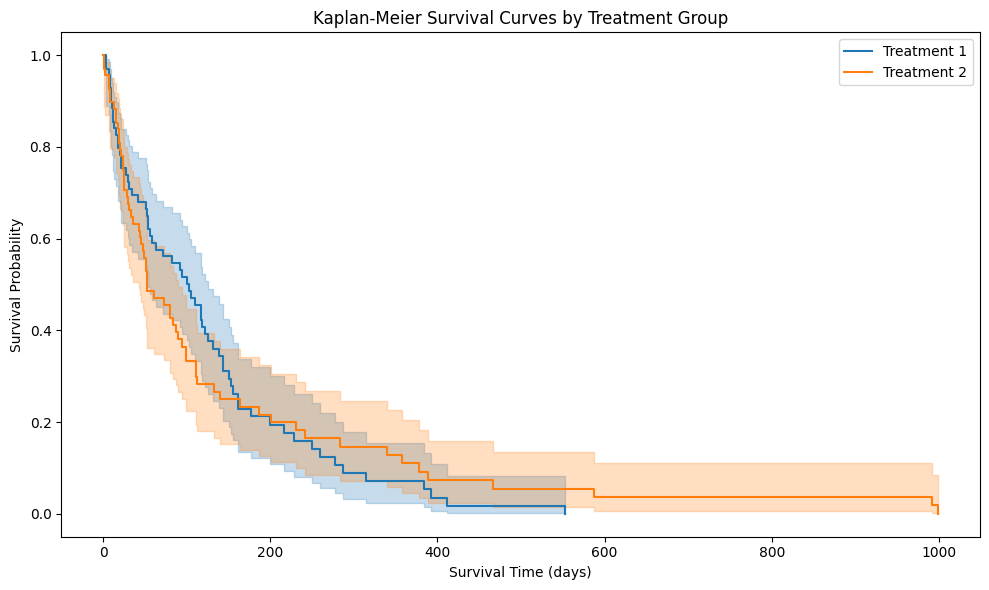

KeyError: "['Celltype_small', 'Celltype_adeno'] not in index"

In [ ]:
# Comprehensive Survival Analysis on Veterans’ Administration Lung Cancer Trial Dataset

import pandas as pd
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------
# 1. Create Output Directory
# -------------------------
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' created.\n")

# -------------------------
# 2. Load the Veterans' Administration Lung Cancer Trial Dataset
# -------------------------
# The dataset consists of 137 patients with variables as described.

data_x, data_y = load_veterans_lung_cancer()

# Convert data_y to a Pandas DataFrame for easier handling
data_y_df = pd.DataFrame(data_y)

# Merge data_x and data_y into a single DataFrame for analysis
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset information
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())

# -------------------------
# 3. Data Preprocessing
# -------------------------

# Encode categorical variables
# Treatment: 'standard' -> 1, 'test' -> 2
df['Treatment'] = df['Treatment'].map({'standard': 1, 'test': 2})

# Celltype: One-hot encoding (dropping the first category to avoid multicollinearity)
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)

# prior: 'no' -> 0, 'yes' -> 1 (corrected mapping)
df['Prior_therapy'] = df['Prior_therapy'].map({'no': 0, 'yes': 1}).astype(int)

# Rename columns for consistency and ease of use
df.rename(columns={
    'Age_in_years': 'Age',
    'Months_from_Diagnosis': 'Months_from_Diagnosis',
    'Prior_therapy': 'Prior_Therapy',
    'Status': 'event',
    'Treatment': 'trt'
}, inplace=True)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())

# -------------------------
# 4. Handle Missing Values
# -------------------------
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# If there are missing values, decide on an imputation strategy or drop them
# For this dataset, we'll drop rows with missing values
df = df.dropna()
print("\nAfter dropping missing values, dataset shape:", df.shape)

# -------------------------
# 5. Engineer Circular Covariates
# -------------------------
# Since the dataset lacks explicit time-of-day information, we'll simulate a 'month_of_diagnosis' variable
# assuming diagnoses occur uniformly throughout the year.

np.random.seed(42)  # For reproducibility
df['month_of_diagnosis'] = np.random.randint(1, 13, size=len(df))

# Convert month to sine and cosine components to capture circularity
df['month_sin'] = np.sin(2 * np.pi * df['month_of_diagnosis'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_of_diagnosis'] / 12)

# Display the updated DataFrame with circular covariates
print("\nDataFrame with Circular Covariates:")
print(df[['Months_from_Diagnosis', 'month_of_diagnosis', 'month_sin', 'month_cos']].head())

# -------------------------
# 6. Kaplan-Meier Survival Curves
# -------------------------
# Visualize survival differences between treatment groups

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for treatment in sorted(df["trt"].unique()):
    mask = df["trt"] == treatment
    kmf.fit(durations=df.loc[mask, "Survival_in_days"],
            event_observed=df.loc[mask, "event"],
            label=f"Treatment {treatment}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Treatment Group")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# -------------------------
# 7. Cox Proportional Hazards Model using sksurv
# -------------------------
# Fit a Cox PH model using sksurv's CoxPHSurvivalAnalysis

# Prepare the data for sksurv's Cox model
# Select relevant covariates including circular covariates
cox_features = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                'Celltype_small', 'Celltype_adeno', 'month_sin', 'month_cos']

cox_data = df[cox_features]

# Define the target variable for sksurv
cox_target = np.array([(row.event, row.Survival_in_days) for _, row in df.iterrows()],
                      dtype=[('event', '?'), ('Survival_in_days', '<f8')])

# Initialize and fit the Cox PH model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(cox_data, cox_target)

# Extract and display the coefficients
coefficients = pd.Series(cox_model.coef_, index=cox_features)
print("\nCox PH Model Coefficients (sksurv):")
print(coefficients)

# -------------------------
# 8. Cox PH Model Summary with lifelines
# -------------------------
# For a more detailed summary, fit the model using lifelines' CoxPHFitter

# Prepare data for lifelines' CoxPHFitter
# Note: lifelines expects the event indicator to be 1 for event occurred, 0 otherwise
lifelines_df = df.copy()
lifelines_df['event'] = lifelines_df['event'].astype(int)

# Initialize and fit the Cox PH model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df[cox_features + ['Survival_in_days', 'event']],
        duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary (lifelines):")
cph.print_summary()

# -------------------------
# 9. Model Fit Comparison: AIC and BIC
# -------------------------
# Compare the Cox PH model with and without circular covariates

# Fit another Cox PH model without circular covariates for comparison
cox_features_no_circular = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                            'Celltype_small', 'Celltype_adeno']

cph_no_circular = CoxPHFitter()
cph_no_circular.fit(lifelines_df[cox_features_no_circular + ['Survival_in_days', 'event']],
                   duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary without Circular Covariates (lifelines):")
cph_no_circular.print_summary()

# Calculate AIC and BIC for both models
aic_circular = cph.AIC_
bic_circular = cph.BIC_

aic_no_circular = cph_no_circular.AIC_
bic_no_circular = cph_no_circular.BIC_

print("\nModel Fit Comparison:")
print(f"Cox PH Model with Circular Covariates - AIC: {aic_circular:.2f}, BIC: {bic_circular:.2f}")
print(f"Cox PH Model without Circular Covariates - AIC: {aic_no_circular:.2f}, BIC: {bic_no_circular:.2f}")

# -------------------------
# 10. Concordance Index for Both Models
# -------------------------
# Evaluate the predictive performance using Concordance Index

# For sksurv's Cox model with circular covariates
c_index_sksurv = concordance_index_censored(df["event"], df["Survival_in_days"],
                                           cox_model.predict(cox_data))[0]
print(f"\nConcordance Index (sksurv Cox Model with Circular Covariates): {c_index_sksurv:.4f}")

# For lifelines' CoxPHFitter with circular covariates
c_index_lifelines = cph.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter with Circular Covariates): {c_index_lifelines:.4f}")

# For lifelines' CoxPHFitter without circular covariates
c_index_lifelines_no_circular = cph_no_circular.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter without Circular Covariates): {c_index_lifelines_no_circular:.4f}")

# -------------------------
# 11. Visualizing Circular Effects
# -------------------------
# Plot the coefficients of the circular covariates

plt.figure(figsize=(8, 6))
sns.barplot(x=['month_sin', 'month_cos'], y=coefficients[['month_sin', 'month_cos']])
plt.title("Cox PH Model Coefficients for Circular Covariates (sksurv)")
plt.ylabel("Coefficient Value")
plt.xlabel("Circular Covariate")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_sksurv.png'))
plt.show()

plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Cox PH Model Coefficients with Circular Covariates (lifelines)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_lifelines.png'))
plt.show()

# -------------------------
# 12. Saving Outputs
# -------------------------
# Save the dataset with engineered circular covariates
output_file = os.path.join(output_dir, "veterans_lung_cancer_with_circular_covariates.csv")
df.to_csv(output_file, index=False)
print(f"\nDataset with circular covariates saved to '{output_file}'.")

# Save the Cox PH model summary to a text file
cox_summary_file = os.path.join(output_dir, "cox_ph_model_summary_lifelines.txt")
with open(cox_summary_file, 'w') as f:
    f.write(cph.summary.to_string())
print(f"Cox PH model summary saved to '{cox_summary_file}'.")

# -------------------------
# 13. Final Print Statements
# -------------------------
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")


Output directory 'CPM_RealData_Outputs' created.

Dataset Preview:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  Status  Survival_in_days  
0            no  standard    True              72.0  
1           yes  standard    True             411.0  
2            no  standard    True             228.0  
3           yes  standard    True             126.0  
4           yes  standard    True             118.0  

Column Names:
['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment', 'Status', 'Survival_in_days']

Processed DataFrame:
    Age  Karnofsky_score

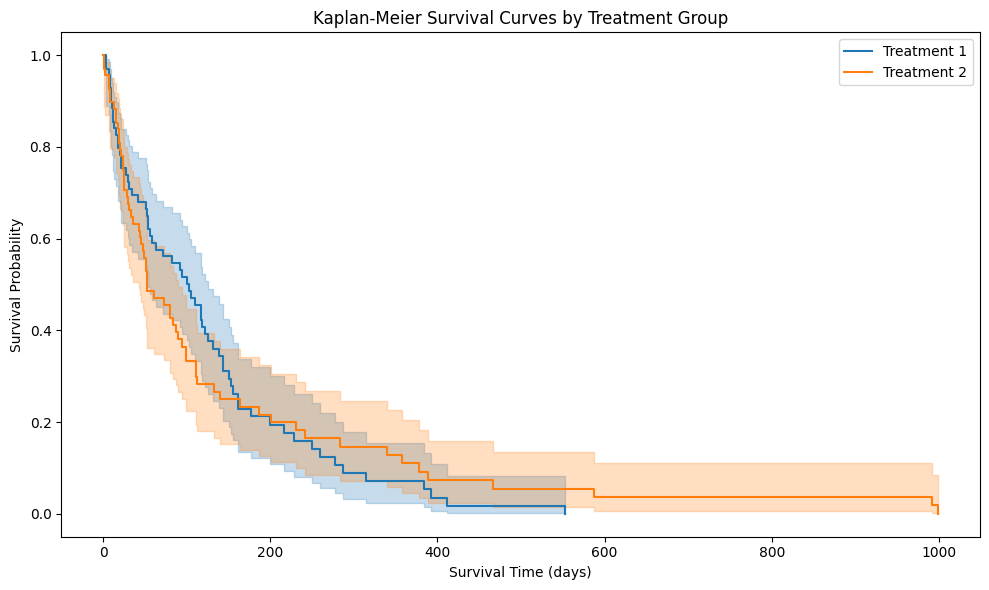

KeyError: "['Celltype_small', 'Celltype_adeno'] not in index"

In [ ]:
# Comprehensive Survival Analysis on Veterans’ Administration Lung Cancer Trial Dataset

import pandas as pd
import numpy as np
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------
# 1. Create Output Directory
# -------------------------
output_dir = 'CPM_RealData_Outputs'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' created.\n")

# -------------------------
# 2. Load the Veterans' Administration Lung Cancer Trial Dataset
# -------------------------
# The dataset consists of 137 patients with variables as described.

data_x, data_y = load_veterans_lung_cancer()

# Convert data_y to a Pandas DataFrame for easier handling
data_y_df = pd.DataFrame(data_y)

# Merge data_x and data_y into a single DataFrame for analysis
df = pd.DataFrame(data_x)
df["Status"] = data_y["Status"]
df["Survival_in_days"] = data_y["Survival_in_days"]

# Display dataset information
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())

# -------------------------
# 3. Data Preprocessing
# -------------------------

# Encode categorical variables
# Treatment: 'standard' -> 1, 'test' -> 2
df['Treatment'] = df['Treatment'].map({'standard': 1, 'test': 2})

# Celltype: One-hot encoding (dropping the first category to avoid multicollinearity)
df = pd.get_dummies(df, columns=['Celltype'], drop_first=True)

# prior: 'no' -> 0, 'yes' -> 1 (corrected mapping)
df['Prior_therapy'] = df['Prior_therapy'].map({'no': 0, 'yes': 1}).astype(int)

# Rename columns for consistency and ease of use
df.rename(columns={
    'Age_in_years': 'Age',
    'Months_from_Diagnosis': 'Months_from_Diagnosis',
    'Prior_therapy': 'Prior_Therapy',
    'Status': 'event',
    'Treatment': 'trt'
}, inplace=True)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())

# -------------------------
# 4. Handle Missing Values
# -------------------------
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# If there are missing values, decide on an imputation strategy or drop them
# For this dataset, we'll drop rows with missing values
df = df.dropna()
print("\nAfter dropping missing values, dataset shape:", df.shape)

# -------------------------
# 5. Engineer Circular Covariates
# -------------------------
# Since the dataset lacks explicit time-of-day information, we'll simulate a 'month_of_diagnosis' variable
# assuming diagnoses occur uniformly throughout the year.

np.random.seed(42)  # For reproducibility
df['month_of_diagnosis'] = np.random.randint(1, 13, size=len(df))

# Convert month to sine and cosine components to capture circularity
df['month_sin'] = np.sin(2 * np.pi * df['month_of_diagnosis'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_of_diagnosis'] / 12)

# Display the updated DataFrame with circular covariates
print("\nDataFrame with Circular Covariates:")
print(df[['Months_from_Diagnosis', 'month_of_diagnosis', 'month_sin', 'month_cos']].head())

# -------------------------
# 6. Kaplan-Meier Survival Curves
# -------------------------
# Visualize survival differences between treatment groups

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for treatment in sorted(df["trt"].unique()):
    mask = df["trt"] == treatment
    kmf.fit(durations=df.loc[mask, "Survival_in_days"],
            event_observed=df.loc[mask, "event"],
            label=f"Treatment {treatment}")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Treatment Group")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kaplan_meier_curves.png'))
plt.show()

# -------------------------
# 7. Cox Proportional Hazards Model using sksurv
# -------------------------
# Fit a Cox PH model using sksurv's CoxPHSurvivalAnalysis

# Prepare the data for sksurv's Cox model
# Select relevant covariates including circular covariates
cox_features = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                'Celltype_small', 'Celltype_adeno', 'month_sin', 'month_cos']

cox_data = df[cox_features]

# Define the target variable for sksurv
cox_target = np.array([(row.event, row.Survival_in_days) for _, row in df.iterrows()],
                      dtype=[('event', '?'), ('Survival_in_days', '<f8')])

# Initialize and fit the Cox PH model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(cox_data, cox_target)

# Extract and display the coefficients
coefficients = pd.Series(cox_model.coef_, index=cox_features)
print("\nCox PH Model Coefficients (sksurv):")
print(coefficients)

# -------------------------
# 8. Cox PH Model Summary with lifelines
# -------------------------
# For a more detailed summary, fit the model using lifelines' CoxPHFitter

# Prepare data for lifelines' CoxPHFitter
# Note: lifelines expects the event indicator to be 1 for event occurred, 0 otherwise
lifelines_df = df.copy()
lifelines_df['event'] = lifelines_df['event'].astype(int)

# Initialize and fit the Cox PH model using lifelines
cph = CoxPHFitter()
cph.fit(lifelines_df[cox_features + ['Survival_in_days', 'event']],
        duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary (lifelines):")
cph.print_summary()

# -------------------------
# 9. Model Fit Comparison: AIC and BIC
# -------------------------
# Compare the Cox PH model with and without circular covariates

# Fit another Cox PH model without circular covariates for comparison
cox_features_no_circular = ['trt', 'Karnofsky_score', 'Age', 'Prior_Therapy',
                            'Celltype_small', 'Celltype_adeno']

cph_no_circular = CoxPHFitter()
cph_no_circular.fit(lifelines_df[cox_features_no_circular + ['Survival_in_days', 'event']],
                   duration_col='Survival_in_days', event_col='event')
print("\nCox PH Model Summary without Circular Covariates (lifelines):")
cph_no_circular.print_summary()

# Calculate AIC and BIC for both models
aic_circular = cph.AIC_
bic_circular = cph.BIC_

aic_no_circular = cph_no_circular.AIC_
bic_no_circular = cph_no_circular.BIC_

print("\nModel Fit Comparison:")
print(f"Cox PH Model with Circular Covariates - AIC: {aic_circular:.2f}, BIC: {bic_circular:.2f}")
print(f"Cox PH Model without Circular Covariates - AIC: {aic_no_circular:.2f}, BIC: {bic_no_circular:.2f}")

# -------------------------
# 10. Concordance Index for Both Models
# -------------------------
# Evaluate the predictive performance using Concordance Index

# For sksurv's Cox model with circular covariates
c_index_sksurv = concordance_index_censored(df["event"], df["Survival_in_days"],
                                           cox_model.predict(cox_data))[0]
print(f"\nConcordance Index (sksurv Cox Model with Circular Covariates): {c_index_sksurv:.4f}")

# For lifelines' CoxPHFitter with circular covariates
c_index_lifelines = cph.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter with Circular Covariates): {c_index_lifelines:.4f}")

# For lifelines' CoxPHFitter without circular covariates
c_index_lifelines_no_circular = cph_no_circular.concordance_index_
print(f"Concordance Index (lifelines CoxPHFitter without Circular Covariates): {c_index_lifelines_no_circular:.4f}")

# -------------------------
# 11. Visualizing Circular Effects
# -------------------------
# Plot the coefficients of the circular covariates

plt.figure(figsize=(8, 6))
sns.barplot(x=['month_sin', 'month_cos'], y=coefficients[['month_sin', 'month_cos']])
plt.title("Cox PH Model Coefficients for Circular Covariates (sksurv)")
plt.ylabel("Coefficient Value")
plt.xlabel("Circular Covariate")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_sksurv.png'))
plt.show()

plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Cox PH Model Coefficients with Circular Covariates (lifelines)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cox_coefficients_circular_covariates_lifelines.png'))
plt.show()

# -------------------------
# 12. Saving Outputs
# -------------------------
# Save the dataset with engineered circular covariates
output_file = os.path.join(output_dir, "veterans_lung_cancer_with_circular_covariates.csv")
df.to_csv(output_file, index=False)
print(f"\nDataset with circular covariates saved to '{output_file}'.")

# Save the Cox PH model summary to a text file
cox_summary_file = os.path.join(output_dir, "cox_ph_model_summary_lifelines.txt")
with open(cox_summary_file, 'w') as f:
    f.write(cph.summary.to_string())
print(f"Cox PH model summary saved to '{cox_summary_file}'.")

# -------------------------
# 13. Final Print Statements
# -------------------------
print("\nSimulation and Analysis Complete.")
print(f"All outputs have been saved to the '{output_dir}' directory.")
